<a href="https://colab.research.google.com/github/CalumGabbutt/CCMI-CWIG-Bayes/blob/main/2_NPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting simulation-based models to data using neural networks

In this tutorial, we will use the Python SBI package (https://sbi-dev.github.io/sbi/latest) to showcase how to fit a simulation-based model to data. The model is a stochastic version of how stem cell dynamics pattern methylation data, described here: https://doi.org/10.1038/s41587-021-01109-w


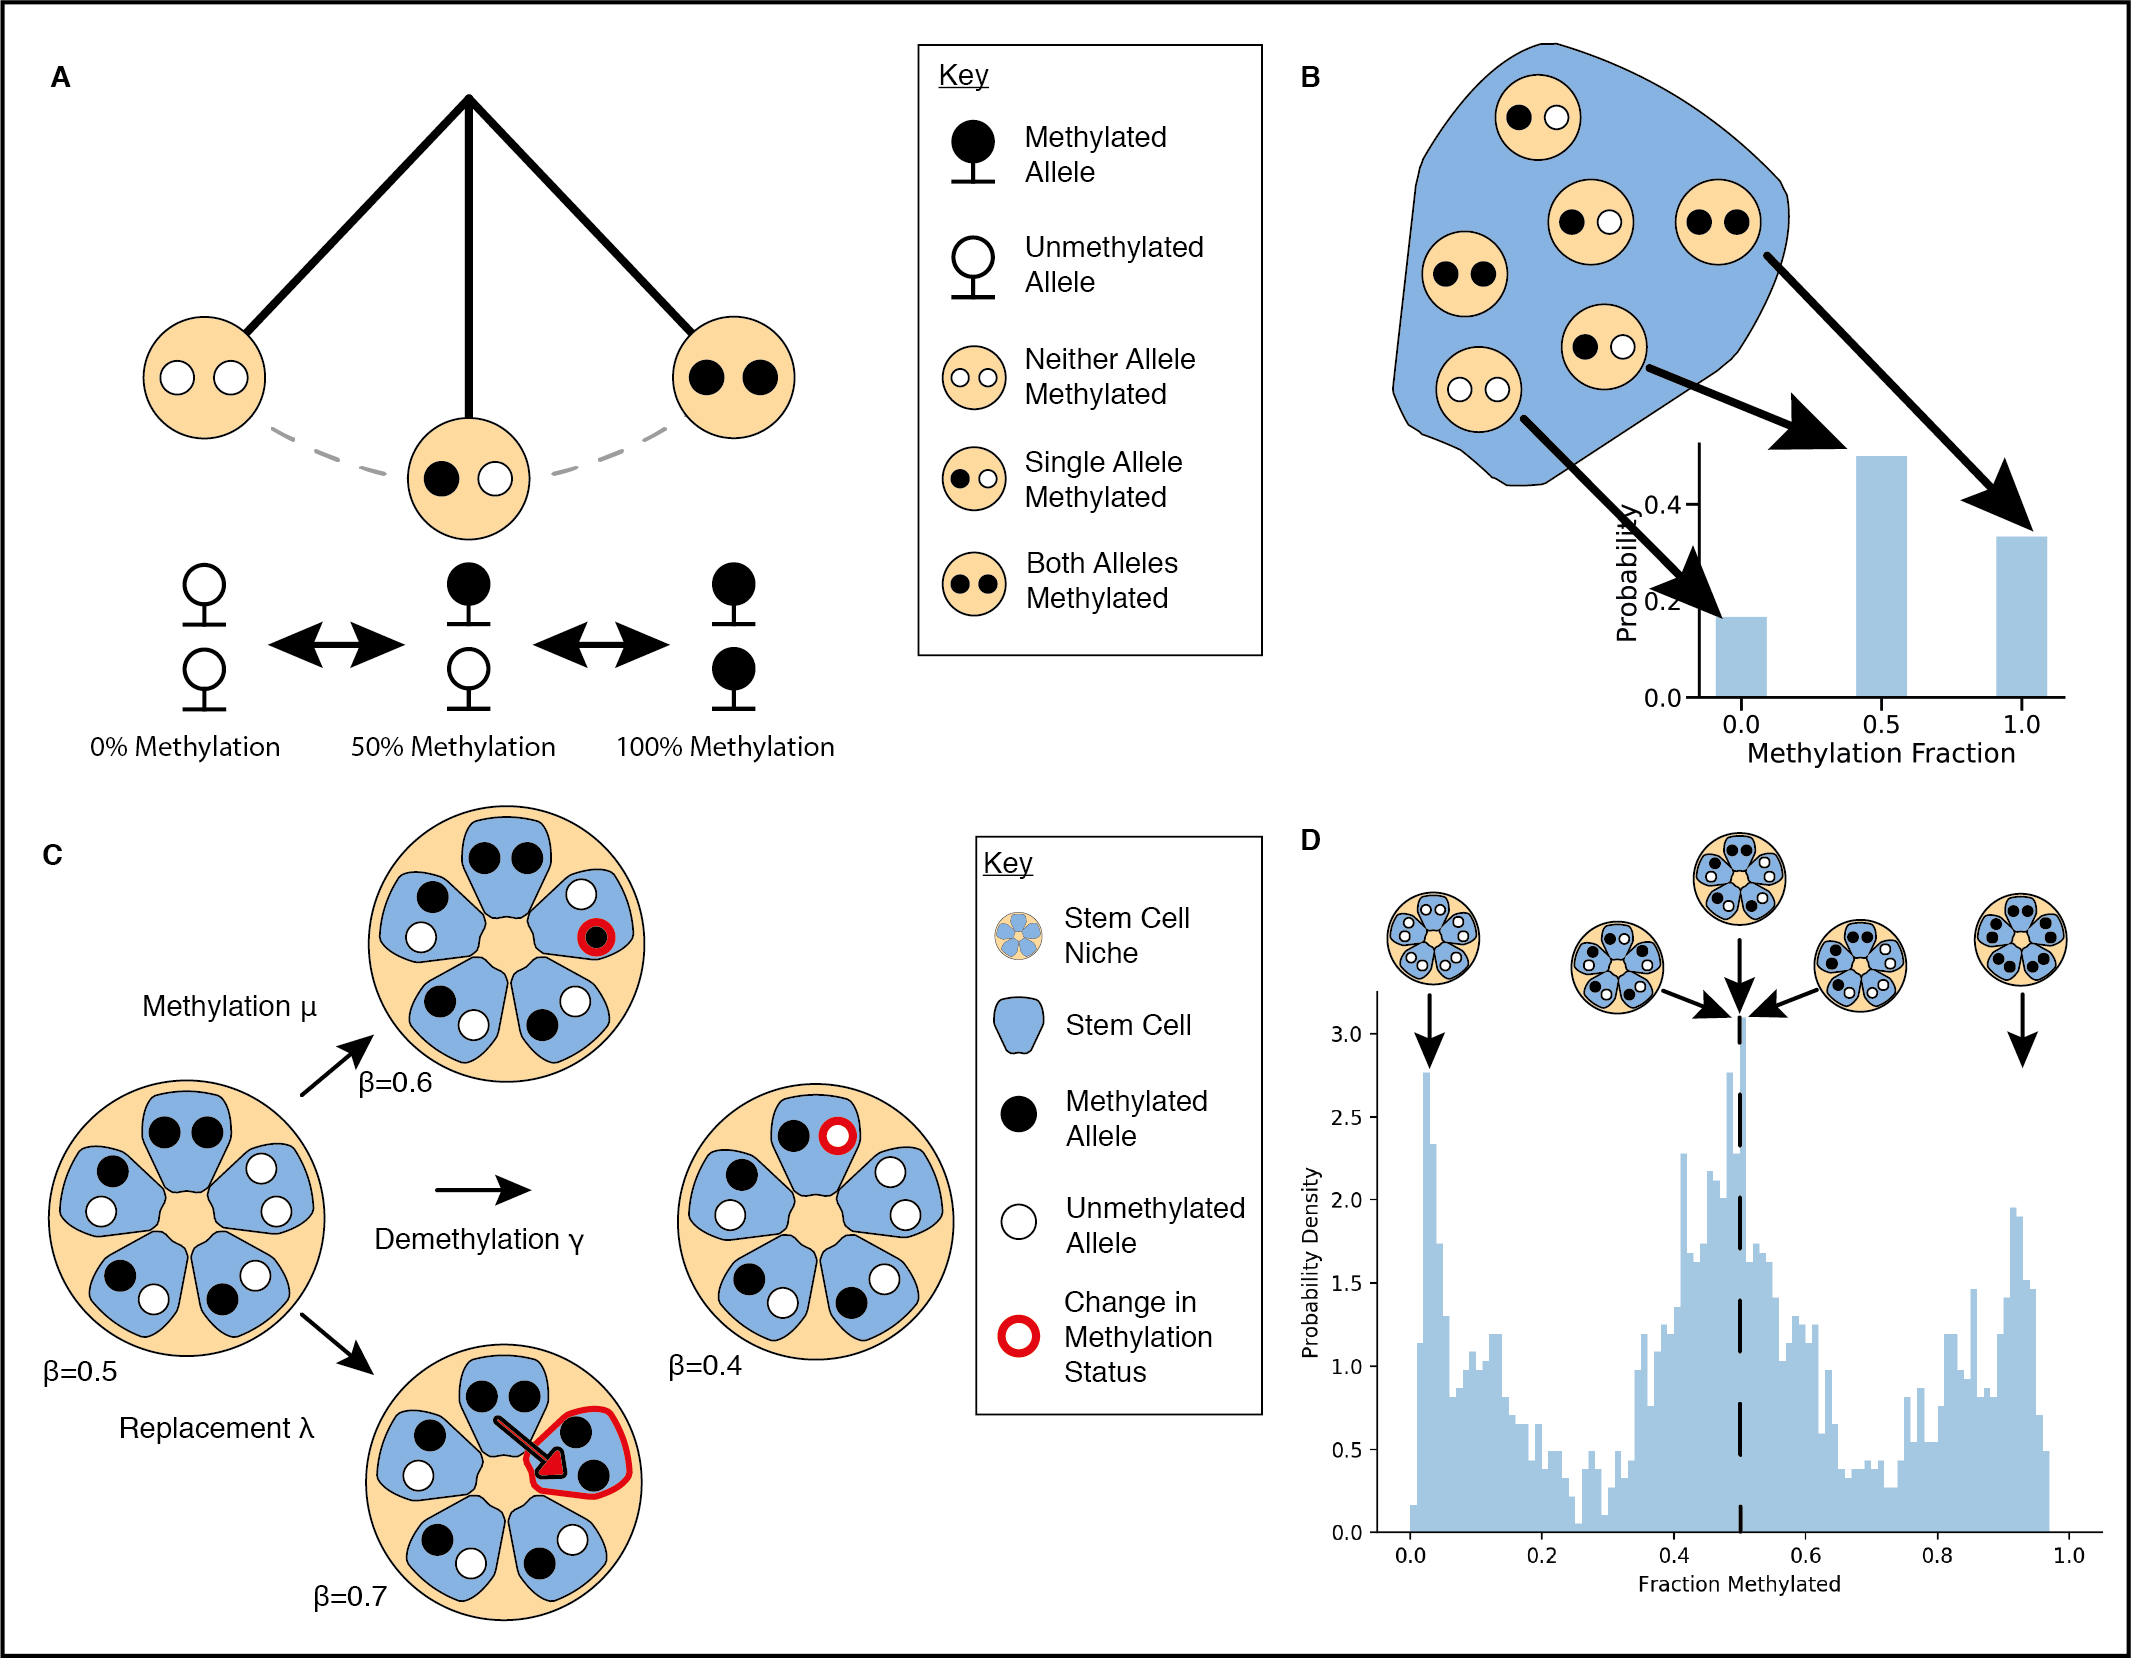

This install cell can take a while, depending on download speeds. Because our networks are generally shallow and not-tall, we don't expect a speed up by running on a GPU, so you can keep the default runtime type as CPU.

In [ ]:
!pip install sbi
!pip install corner

In [ ]:
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import seaborn as sns
from scipy import stats
import corner
import os
import pickle

import torch
from torch.distributions import (
    Beta,
    LogNormal,
    HalfNormal,
    Uniform,
    TransformedDistribution,
    Categorical)
from torch.distributions.transforms import AffineTransform

from sbi.analysis import pairplot, conditional_potential
from sbi.inference import (
    NPE,
    simulate_for_sbi,
    MCMCPosterior,
    posterior_estimator_based_potential)
from sbi.utils import MultipleIndependent
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

The biological system we will be modelling is that of the stem cells that lie at the base of each colonic crypt (test-tube shaped structures that make up the large intestine). Previous work in mouse has shown that each crypt consists of a small number of stem cells which are able to divide and displace (i.e. replace) the other stem cells over time.

In mouse, this means each crypt stochastically but inevitably ends up being dominated by the descendents of just 1 stem cell after ~1 month. However, in human it was unclear how many stem cells existed per crypt, and how often they replaced each other. In our work, we used a system of ODEs to model how naturally occurring changes in DNA methylation varied as a function of the stem cell dynamics. This allowed us to compute a likelihood, so we could apply traditional Bayesian methods to learn these parameters for an individual crypt. Here, we are going to use a stochastic simulator and neural networks as an alternative approach.

First, let's define the simulator functions to model how the distribution of fCpG methylation within a colonic crypt varies as a function of the replacement rate ( λ ), the epigenetic switching rates ( μ : forward,  𝛾 : backwards) and the parameters determining the noise in the array ( 𝛿 : offset from 0,  𝜂 : offset from 1,  𝜅 : precision of the array).

Notice how the simulation mostly relies on numpy arrays and functions, rather than torch ones. This is a nice feature of the SBI package, in that the simulation function can be written however you like, even in another programming language like Julia or C++, as long as they store simulation outputs in a format that can be read from Python.

In [ ]:
def initialise_stemcell_niche(S, N):
    """
    Initialises the stemcell niche as a clonal population of S stem cells
    at N fCpGs. The poopulation is assumed to be homozygous methylated or
    demethylated at t=0

    Arguments:
        S: Number of stem cells in the niche - int >= 1
        N: Number of fCpGs to consider - int >= 1
    Returns:
        stemcells: A 3D  numpy array representing the stemcell niche,
                    where the first index determines the cell, the second
                    index determines the DNA allele and the third index
                    determines the CpG site - np.array[:,:,:]
    """

    # Generate a random methylation pattern
    rng = np.random.default_rng()
    allele = rng.choice([True, False], size=N)

    # Create a 3D array representing the stemcell niche,
    dna = [copy.deepcopy(allele) for i in range(2)]
    dna = np.stack(dna)
    stemcells = np.stack([copy.deepcopy(dna) for i in range(S)])

    return stemcells

def select_adjacent_cells(S):
    """
    Randomly selects 2 adjacent cell indices, imposing periodic boundary
    conditions

    Arguments:
        S: Number of stem cells in the niche - int >= 1
    Returns:
        cells: Pair of randomly selected adjacent indices - tuple(int,int)
    """

    rng = np.random.default_rng()

    # Select the first cell at random, then pick an adjacent cell at random
    cell1 = rng.integers(S)
    cell2 = rng.choice([(cell1 - 1) % S, (cell1 + 1) % S])

    cells = (cell1, cell2)

    return cells

def methylation_sim(lam, mu, gamma, S, age, N):
    """
    Simulates the evolution of fCpG methylation in a well-mixed population of
    stem cells

    Arguments:
        lam: Replacement rate of one stem cell by another (/year) - float > 0
        mu: Methylation rate (/year/allele) - float >= 0
        gamma: Methylation rate (/year/allele) - float >= 0
        S: Number of stem cells in the niche - int >= 1
        age: Length of time to simulate the process for (years) - float > 0
        N: Number of fCpGs to consider - int >= 1
    Returns:
        stemcells: A binary 3D numpy array representing the stemcell niche,
                    where the first index determines the cell, the second
                    index determines the DNA strand and the third index
                    determines the CpG site - np.array[:,:,:]
    """

    # Intialise the stemcell niche
    stemcells = initialise_stemcell_niche(S, N)

    rng = np.random.default_rng()

    # Use a Gillepsie algorithm to model individual CpG changing methylation
    # status and the stem cells replacing each other
    t = 0
    counter = 0
    while t < age:
        # Draw the time until the next replacement event, assuming the
        # replacements are Poisson distributed
        twait = 1 / (lam * S) * np.log(1 / random.random())

        if t + twait < age:

            t += twait

            # Count the number of methylated/non-methylated sites
            num_on = np.count_nonzero(stemcells)
            num_off = 2*N*S - num_on

            # Create a copy of the stemcells array to act as a mask
            boolean_mask = copy.deepcopy(stemcells)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was methylated at time t
            p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)

            # For each site methylated at time t, draw from a random distribution
            # with the above probability to see whether it is still methylated
            stemcells[boolean_mask] = rng.binomial(1, p_given_on, num_on)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was not methylated at time t
            p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))

            # For each site unmethylated at time t, draw from a random distribution
            # with the above probability to see whether it is methylated
            stemcells[~boolean_mask] = rng.binomial(1, p_given_off, num_off)

            # Now that we have taken care of any mutations that have occured,
            # pick 2 cells at random, one to replace the other
            cells = select_adjacent_cells(S)
            stemcells[cells[0]] = copy.deepcopy(stemcells[cells[1]])

            counter += 1

        else:
            twait = age - t
            t += twait

            # Count the number of methylated/non-methylated sites
            num_on = np.count_nonzero(stemcells)
            num_off = 2*N*S - num_on

            # Create a copy of the stemcells array to act as a mask
            boolean_mask = copy.deepcopy(stemcells)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was methylated at time t
            p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
            # For each site methylated at time t, draw from a random distribution
            # with the above probability to see whether it is still methylated
            stemcells[boolean_mask] = rng.binomial(1, p_given_on, num_on)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was not methylated at time t
            p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))

            # For each site unmethylated at time t, draw from a random distribution
            # with the above probability to see whether it is methylated
            stemcells[~boolean_mask] = rng.binomial(1, p_given_off, num_off)

            break

    return stemcells

def beta_convert_params(mean, kappa):
    """
    Convert mean/dispersion parameterization of a beta distribution to the ones
    scipy supports

    Arguments:
        mean: Mean of the beta distribution - 0 < float < 1
        kappa: Precision of the beta distribution - float > 0

    Returns:
        a, b: Standard parameterisation of the beta distibution

    """

    if torch.is_tensor(kappa):
      if torch.any(kappa <= 0):
          raise Exception("kappa must be greater than 0")
    else:
      if np.any(kappa <= 0):
          raise Exception("kappa must be greater than 0")

    if torch.is_tensor(mean):
      if torch.any(mean <= 0) or torch.any(mean >= 1):
          raise Exception("mu must be between 0 and 1")
    else:
      if np.any(mean <= 0) or np.any(mean >= 1):
          raise Exception("mu must be between 0 and 1")

    a = kappa * mean
    b = kappa * (1- mean)

    return a, b

def beta_rvs(mean, kappa, **kwargs):
    """
    Convert mean/dispersion parameterization of a beta distribution to the ones
    scipy supports

    Arguments:
        mean: Mean of the beta distribution - 0 < float < 1
        kappa: Precision of the beta distribution - float > 0

    Returns:
        a, b: Standard parameterisation of the beta distibution
    """

    a, b = beta_convert_params(mean, kappa)

    return stats.beta.rvs(a, b, **kwargs)

def generate_data(S, lam, mu, gamma, delta, eta, kappa, age, N):

    stemcells = methylation_sim(lam, mu, gamma, S, age, N)

    mean_beta = np.mean(np.mean(stemcells, axis = 0), axis = 0)

    beta_obs = beta_rvs((eta - delta) * mean_beta + delta, kappa)

    return beta_obs

def lognormal_convert_params(mean, sigma):
    """
    Convert mean/std parameterization of a beta distribution to the ones
    scipy supports
    """

    if np.any(mean <= 0):
        raise Exception("mean must be greater than 0")
    elif np.any(sigma <= 0) :
        raise Exception("sigma must be greater than 0")

    log_mean = np.log(mean) - 0.5 * np.log1p(sigma**2 / mean**2)
    log_std = np.sqrt(np.log1p(sigma**2 / mean ** 2))

    return log_mean, log_std

Because the number of stem cells is a discrete parameter, we will have to be a bit careful about how we define constructing a density for it, so for our first pass, let's fix the number of stem cells, patient age and the number of fCpGs.